In [1]:
# Install required package
import sys
!{sys.executable} -m pip install --user --upgrade steam-nb-api

import os
from pathlib import Path
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.lines as lines

from steam_nb_api.ledet.ParametersLEDET import ParametersLEDET
from steam_nb_api.utils import misc
from steam_nb_api.roxie_parser import MagneticCoil
from steam_nb_api.utils.SelfMutualInductanceCalculation import SelfMutualInductanceCalculation

from steam_nb_api.roxie_parser import CableDatabase
from steam_nb_api.roxie_parser import ConductorPosition
from steam_nb_api.roxie_parser.geometricFunctions import close_pairs_ckdtree, close_pairs_pdist

Requirement already up-to-date: steam-nb-api in /eos/home-e/emm/.local/lib/python3.7/site-packages (0.2.33)


# Global variables

In [2]:
nameMagnet = 'MED_C_COMB'

# Define style for plots
selectedFont = {'fontname':'DejaVu Sans', 'size':14}

# If this variable is set to True, many comments will be displayed
verbose = False

# Generate magnet geometry parsing .data and .cadata files

File with cable database: /eos/home-e/emm/SWAN_projects/steam-notebooks/steam-ledet-input/resources/roxie.cadata
Block definition parameters have 28 rows
Group definition parameters have 4 rows
Transformation definition parameters have 0 rows
typexy = 0: No symmetry action.
typexy = 0: No symmetry action.
typexy = 0: No symmetry action.
typexy = 0: No symmetry action.



<IPython.core.display.Javascript object>


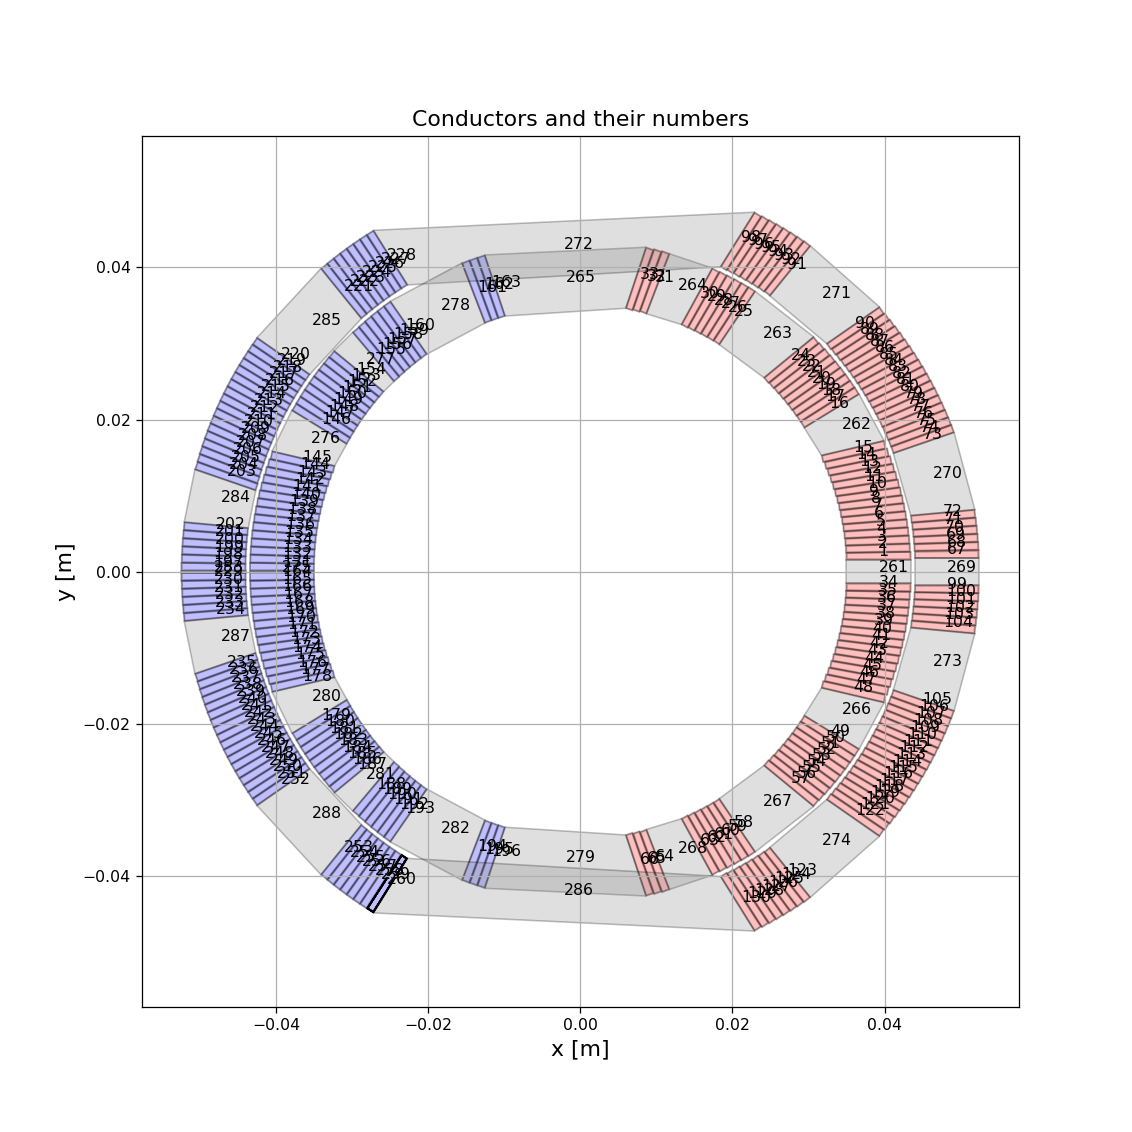

In [3]:
# Select ROXIE .cadata file with conductor data
currentDirectory = Path(os.path.split(os.getcwd())[0])
fileNameCadata = os.path.join(currentDirectory,'resources','roxie.cadata')
fileNameData = nameMagnet + '_All_WithIron_NoSelfField.data'

# Define the magnetic coil
definedMagneticCoil = MagneticCoil.MagneticCoil()
xPos, yPos, iPos, xBarePos, yBarePos, xS, yS, iS = definedMagneticCoil.generateCoilGeometry(fileNameData, fileNameCadata, verbose=verbose)

# Array, that defines each group--> [No. of Layers (Vertical), Layers per Group(horizontal)]
GeoArr = [[1,15],[1,9],[1,6],[1,3]]*2+[[1,6],[1,18],[1,8]]*2 + [[1,15],[1,9],[1,6],[1,3]]*2+[[1,6],[1,18],[1,8]]*2
#Define neighboring conductors, between whom wedges should be defined
WedgeNeighbors = [[1,34],[15,16],[24,25],[30,31],[33,163],[48,49],[57,58],[63,64],[67,99],[72,73],[90,91],[228,98],
                [104,105],[122,123],[131,164],[145,146],[154,155],[160,161],[196,66],[178,179],
                [187,188],[193,194],[197,229],[202,203],[220,221],[260,130],
                [234,235],[252,253]]

#Extract Edges
xPosWedge = []
yPosWedge = []
for i in range(len(WedgeNeighbors)):
    #Left-Inner-Point
    if xPos[WedgeNeighbors[i][0]-1][0] != xPos[WedgeNeighbors[i][1]-1][0]:
        Idx0 = np.argmin([max(xPos[WedgeNeighbors[i][0]-1][0],xPos[WedgeNeighbors[i][0]-1][1]),
                          max(xPos[WedgeNeighbors[i][1]-1][0],xPos[WedgeNeighbors[i][1]-1][1])])
        Idx0_0 = np.argmax([xPos[WedgeNeighbors[i][Idx0]-1][0],xPos[WedgeNeighbors[i][Idx0]-1][1]])
    else:
        Idx0 = np.argmin([max(yPos[WedgeNeighbors[i][0]-1][0],yPos[WedgeNeighbors[i][0]-1][1]),
                          max(yPos[WedgeNeighbors[i][1]-1][0],yPos[WedgeNeighbors[i][1]-1][1])])
        Idx0_0 = np.argmax([yPos[WedgeNeighbors[i][Idx0]-1][0],yPos[WedgeNeighbors[i][Idx0]-1][1]])
    Pos0 = xPos[WedgeNeighbors[i][Idx0]-1][Idx0_0]
    yPos0 = yPos[WedgeNeighbors[i][Idx0]-1][Idx0_0]
    #Left-Outer-Point
    if Idx0_0 == 0: 
        Pos3 = xPos[WedgeNeighbors[i][Idx0]-1][3]
        yPos3 = yPos[WedgeNeighbors[i][Idx0]-1][3]
    else: 
        Pos3 = xPos[WedgeNeighbors[i][Idx0]-1][2]
        yPos3 = yPos[WedgeNeighbors[i][Idx0]-1][2]
    #Right-Inner-Point
    Idx1 = 1 - Idx0
    if xPos[WedgeNeighbors[i][0]-1][0] != xPos[WedgeNeighbors[i][1]-1][0]:
        Idx1_0 = np.argmin([xPos[WedgeNeighbors[i][Idx1]-1][0],xPos[WedgeNeighbors[i][Idx1]-1][1]])
    else:
        Idx1_0 = np.argmin([yPos[WedgeNeighbors[i][Idx1]-1][0],yPos[WedgeNeighbors[i][Idx1]-1][1]])
    Pos1 = xPos[WedgeNeighbors[i][Idx1]-1][Idx1_0]   
    #Right-Outer-Point
    if Idx1_0 == 0: 
        Pos2 = xPos[WedgeNeighbors[i][Idx1]-1][3]
        yPos2 = yPos[WedgeNeighbors[i][Idx1]-1][3]
    else: 
        Pos2 = xPos[WedgeNeighbors[i][Idx1]-1][2]
        yPos2 = yPos[WedgeNeighbors[i][Idx1]-1][2]
    yPos1 = yPos[WedgeNeighbors[i][Idx1]-1][Idx1_0]
        
    xPosWedge.append([Pos0, Pos1, Pos2, Pos3])
    yPosWedge.append([yPos0, yPos1, yPos2, yPos3])
    xBarePosWedge = [0,0,0,0]
    yBarePosWedge = [0,0,0,0]
    iPosWedge = 0
    xBarePos.append(xBarePosWedge)
    yBarePos.append(yBarePosWedge)
    iPos.append(iPosWedge)

xPos = xPos + xPosWedge
yPos = yPos + yPosWedge

# Plot conductors and their numbers
f = plt.figure(2, figsize=(10, 10))
# Plot edges
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='b', edgecolor='k', alpha=.25)
    elif iPos[c] == 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='grey', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)

    # Plot conductor numbers
    x_ave_cond, y_ave_cond = sum(cXPos) / len(cXPos), sum(cYPos) / len(cYPos)
    plt.text(x_ave_cond, y_ave_cond, '{}'.format(c + 1))

# Plot edges of bare conductors
for c, (cXBarePos, cYBarePos) in enumerate(zip(xBarePos, yBarePos)):
    pt1, pt2, pt3, pt4 = (cXBarePos[0], cYBarePos[0]), (cXBarePos[1], cYBarePos[1]), (cXBarePos[2], cYBarePos[2]), (
    cXBarePos[3], cYBarePos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='b', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)

plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Conductors and their numbers', **selectedFont)
plt.set_cmap('jet')
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.grid()


# Calculate magnetic field lines

<IPython.core.display.Javascript object>


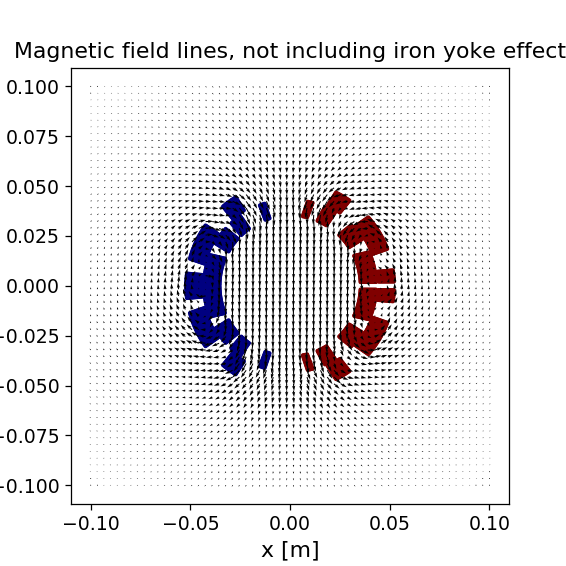

(-0.11000000000000001,
 0.11000000000000001,
 -0.11000000000000001,
 0.11000000000000001)

In [4]:
minMaxX = [-.1, +.1] # to adjust depending on the coil dimensions
minMaxY = [-.1, +.1] # to adjust depending on the coil dimensions
nGridPoints=[60, 60]
Bx_map, By_map, B_map, x_map, y_map = definedMagneticCoil.calculateMagneticFieldGrid(minMaxX, minMaxY, nGridPoints)

# Plot current lines
f = plt.figure(figsize=(5, 5))
plt.scatter(xS, yS, s=2, c=iS)
# Plot magnetic field arrows
q = plt.quiver(x_map, y_map, Bx_map, By_map, color='k')
plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Magnetic field lines, not including iron yoke effect', **selectedFont)
plt.set_cmap('jet')
# cbar = plt.colorbar()
# cbar.set_label('Magnetic field [T]', **selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

# Field maps from ROXIE

In [5]:
fileName = nameMagnet + '_All_WithIron_WithSelfField.map2d'
Strands_per_Turn = 34
Wedges = True

if Wedges:
    # Read file
    file = open(fileName, "r")
    fileContent = file.read()

    # Separate rows and construct new Wedge Map2D data
    Number_Wedges = len(WedgeNeighbors)
    fileContentByRow = fileContent.split("\n")
    NewMap2d = np.array([[ None for x in range(10)] 
                 for y in range(2,len(fileContentByRow)-1+Number_Wedges)])
    
    # Construct Wedge Fieldmaps
    wedge_length = np.sqrt((xPos[0][0]-xPos[0][3])**2+(yPos[0][0]-yPos[0][3])**2)
    x_ave_wedge = (np.sum(xPosWedge, axis=1)/4 +0) *1000 #x-Offset
    y_ave_wedge = (np.sum(yPosWedge, axis=1)/4 -0) *1000 #y-Offset
    
    #Artificially adjust pole wedges because of size -- Note: Not generic, do not copy for other than MED_C_COMB
    y_ave_wedge[11] = 48.25
    y_ave_wedge[25] = -48.25
    
    
    #Define Total numbers
    TotalCond = len(fileContentByRow)-3
    TotalTurn = np.floor(TotalCond/Strands_per_Turn)
    TotalGroups = 0
    for i in range(len(GeoArr)):
        TotalGroups = TotalGroups + GeoArr[i][0]
    
    # Create wedges
    wedge_map2d = []
    wedge_outplanes = []
    wedge_areas = []
    wedge_midplanes = []
    #try:
    for i in range(Number_Wedges):
        #Calculate the two parallel sides of the trapezoid
        midplane = np.sqrt(abs(xPosWedge[i][0] - xPosWedge[i][1])**2 + abs(yPosWedge[i][0] - yPosWedge[i][1])**2)
        wedge_midplanes.append(midplane)
        outplane = np.sqrt(abs(xPosWedge[i][2] - xPosWedge[i][3])**2 + abs(yPosWedge[i][2] - yPosWedge[i][3])**2)
        wedge_outplanes.append(outplane)
        #Trapezoidal area
        alpha = np.arccos((outplane-midplane)/(2*wedge_length))
        h = wedge_length*np.sin(alpha)
        wedge_area= (midplane+outplane)/2 * h
        wedge_areas.append(wedge_area)

        #Create Wedge list (1 row in the map2d files)
        if i<Number_Wedges/2:
            new_wedge = [int(TotalGroups/2 + i+1), int(TotalTurn/2 +i+1), int(TotalCond/2 +i+1), \
                        x_ave_wedge[i], y_ave_wedge[i], 0,0, wedge_area* 1000000, 0, 0]
            wedge_map2d.append(new_wedge)
        if i>=Number_Wedges/2:
            new_wedge = [int(TotalGroups+ i+1), int(TotalTurn+i+1), int(TotalCond+i+1), \
                        x_ave_wedge[i], y_ave_wedge[i], 0,0, wedge_area* 1000000, 0, 0]
            wedge_map2d.append(new_wedge)
    Idx_FirstWedgeBlock = int(TotalCond/2)
    NumberHalf_Wedges = int(Number_Wedges/2)
    Idx_SecondWedgeBlock = int(TotalCond+Number_Wedges/2)
   # except:
     #   print("Number of Wedges is not even")

    # Reorder Entries according to GeoArr and Number of Wedges
    WedgeOffset = 0
    for j in range(TotalCond):
        if j>=int((TotalCond)/2):
            WedgeOffset=int(Number_Wedges/2)
        fc = fileContentByRow[j+2]
        NewMap2d[j+WedgeOffset,:]=fc.split()
        NewMap2d[j+WedgeOffset,0]=int(NewMap2d[j+WedgeOffset,0])+WedgeOffset
        NewMap2d[j+WedgeOffset,1]=int(NewMap2d[j+WedgeOffset,1])+WedgeOffset
        NewMap2d[j+WedgeOffset,2]=int(NewMap2d[j+WedgeOffset,2])+WedgeOffset
        
    NewMap2d[Idx_FirstWedgeBlock:Idx_FirstWedgeBlock+NumberHalf_Wedges]=wedge_map2d[0:NumberHalf_Wedges]
    NewMap2d[Idx_SecondWedgeBlock:]=wedge_map2d[NumberHalf_Wedges:]

    # Write new .map2d File
    mat = np.matrix(NewMap2d)
    head = np.array(fileContentByRow[0].split()).transpose()
    head_merge = np.array([ None for x in range(10)])
    for i in range(head_merge.shape[0]-1):
        head_merge[i]=head[i]
    head_merge[9] = head[9]+" "+head[10]
    mat = mat.astype(float)
    CondNumbers  = np.array([np.linspace(1,len(fileContentByRow)-3+Number_Wedges,
                                         len(fileContentByRow)-3+Number_Wedges).astype(int)]).transpose()
    mat[:,2] = CondNumbers
    with open(nameMagnet + '_CopperWedges_All_WithIron_WithSelfField.map2d','wb') as f:
        np.savetxt(f,np.array([head_merge]), fmt="%s")
        np.savetxt(f,[""],fmt="%s")
        for row in mat:
            np.savetxt(f,row, fmt=["%i","%i","%i","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f"])
    
    ## Repeat for E1 file
    fileName = nameMagnet + '_E1_WithIron_NoSelfField.map2d'
    # Read file
    file = open(fileName, "r")
    fileContent = file.read()

    # Separate rows
    fileContentByRow = fileContent.split("\n")
    NewMap2d = np.array([[ None for x in range(10)] 
                 for y in range(2,len(fileContentByRow)-1+Number_Wedges)])
   # Reorder Entries according to GeoArr and Number of Wedges
    WedgeOffset = 0
    for j in range(TotalCond):
        if j>=int((TotalCond)/2):
            WedgeOffset=int(Number_Wedges/2)
        fc = fileContentByRow[j+2]
        NewMap2d[j+WedgeOffset,:]=fc.split()
        NewMap2d[j+WedgeOffset,0]=int(NewMap2d[j+WedgeOffset,0])+WedgeOffset
        NewMap2d[j+WedgeOffset,1]=int(NewMap2d[j+WedgeOffset,1])+WedgeOffset
        NewMap2d[j+WedgeOffset,2]=int(NewMap2d[j+WedgeOffset,2])+WedgeOffset
        
    NewMap2d[Idx_FirstWedgeBlock:Idx_FirstWedgeBlock+NumberHalf_Wedges]=wedge_map2d[0:NumberHalf_Wedges]
    NewMap2d[Idx_SecondWedgeBlock:]=wedge_map2d[NumberHalf_Wedges:]

    # Write new .map2d File
    mat = np.matrix(NewMap2d)
    head = np.array(fileContentByRow[0].split()).transpose()
    head_merge = np.array([ None for x in range(10)])
    for i in range(head_merge.shape[0]-1):
        head_merge[i]=head[i]
    head_merge[9] = head[9]+" "+head[10]
    mat = mat.astype(float)
    CondNumbers  = np.array([np.linspace(1,len(fileContentByRow)-3+Number_Wedges,
                                         len(fileContentByRow)-3+Number_Wedges).astype(int)]).transpose()
    mat[:,2] = CondNumbers
    with open(nameMagnet + '_CopperWedges_E1_WithIron_NoSelfField.map2d','wb') as f:
        np.savetxt(f,np.array([head_merge]), fmt="%s")
        np.savetxt(f,[""],fmt="%s")
        for row in mat:
            np.savetxt(f,row, fmt=["%i","%i","%i","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f"])
            
    ## Repeat for All_WithIron_NoSelfField file
    fileName = nameMagnet + '_All_WithIron_NoSelfField.map2d'
    # Read file
    file = open(fileName, "r")
    fileContent = file.read()

    # Separate rows
    fileContentByRow = fileContent.split("\n")
    NewMap2d = np.array([[ None for x in range(10)] 
                 for y in range(2,len(fileContentByRow)-1+Number_Wedges)])
   # Reorder Entries according to GeoArr and Type Ribbon Cable
    WedgeOffset = 0
    for j in range(TotalCond):
        if j>=int((TotalCond)/2):
            WedgeOffset=int(Number_Wedges/2)
        fc = fileContentByRow[j+2]
        NewMap2d[j+WedgeOffset,:]=fc.split()
        NewMap2d[j+WedgeOffset,0]=int(NewMap2d[j+WedgeOffset,0])+WedgeOffset
        NewMap2d[j+WedgeOffset,1]=int(NewMap2d[j+WedgeOffset,1])+WedgeOffset
        NewMap2d[j+WedgeOffset,2]=int(NewMap2d[j+WedgeOffset,2])+WedgeOffset
        
    NewMap2d[Idx_FirstWedgeBlock:Idx_FirstWedgeBlock+NumberHalf_Wedges]=wedge_map2d[0:NumberHalf_Wedges]
    NewMap2d[Idx_SecondWedgeBlock:]=wedge_map2d[NumberHalf_Wedges:]

    # Write new .map2d File
    mat = np.matrix(NewMap2d)
    head = np.array(fileContentByRow[0].split()).transpose()
    head_merge = np.array([ None for x in range(10)])
    for i in range(head_merge.shape[0]-1):
        head_merge[i]=head[i]
    head_merge[9] = head[9]+" "+head[10]
    mat = mat.astype(float)
    CondNumbers  = np.array([np.linspace(1,len(fileContentByRow)-3+Number_Wedges,
                                         len(fileContentByRow)-3+Number_Wedges).astype(int)]).transpose()
    mat[:,2] = CondNumbers
    with open(nameMagnet + '_CopperWedges_All_WithIron_NoSelfField.map2d','wb') as f:
        np.savetxt(f,np.array([head_merge]), fmt="%s")
        np.savetxt(f,[""],fmt="%s")
        for row in mat:
            np.savetxt(f,row, fmt=["%i","%i","%i","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f"])

Total number of strands in the field-map from ROXIE = 8868
Peak magnetic field in the field-map from ROXIE = 3.4212964355635713 T


<IPython.core.display.Javascript object>


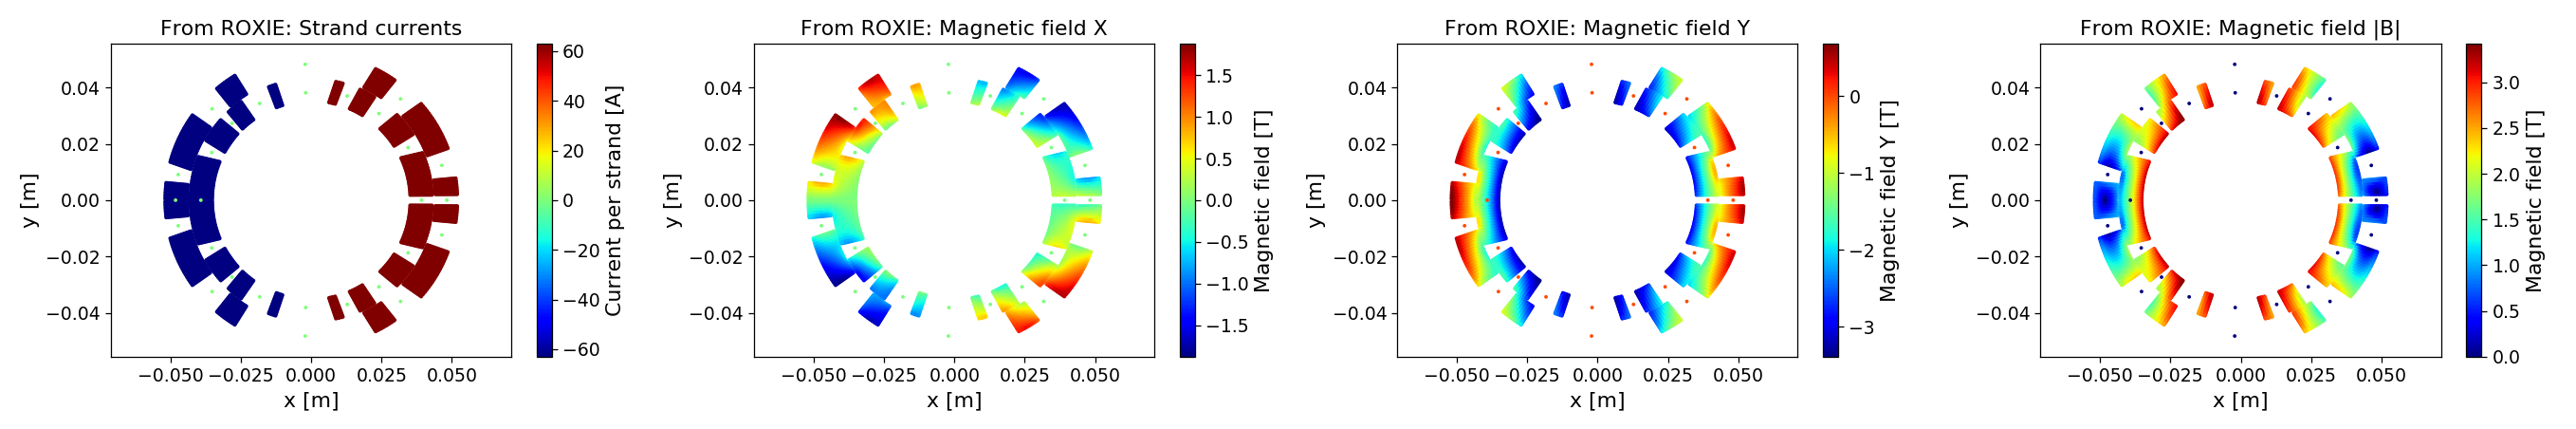

In [6]:
# Acquire data from ROXIE .map2d file
if Wedges:
    fileName = nameMagnet + '_CopperWedges_All_WithIron_WithSelfField.map2d'
else:
    fileName = nameMagnet + '_All_WithIron_WithSelfField.map2d'
headerLines = 1

strandToGroup = np.array([])
strandToHalfTurn = np.array([])
idx = []
x = []
y = []
Bx = []
By = []
Area = []
I = []
fillFactor = []

# Read file
file = open(fileName, "r")
fileContent = file.read()

# Separate rows
fileContentByRow = fileContent.split("\n")

for index in range(len(fileContentByRow)-1):
    if index>headerLines:
        fc = fileContentByRow[index]
        row = fc.split()
#         print(index)
#         print(row)
        strandToGroup = np.hstack([strandToGroup,int(row[0])])
        strandToHalfTurn = np.hstack([strandToHalfTurn,int(row[1])])
        idx = np.hstack([idx,float(row[2])])
        x = np.hstack([x,float(row[3])/1000]) # in [m]
        y = np.hstack([y,float(row[4])/1000]) # in [m]
        Bx = np.hstack([Bx,float(row[5])])
        By = np.hstack([By,float(row[6])])
        Area = np.hstack([Area,float(row[7])])
        I = np.hstack([I,float(row[8])])
        fillFactor = np.hstack([fillFactor,float(row[9])])
        
[dd,c] = np.unique(strandToHalfTurn,return_index=True)
[dd,nT] = np.unique(strandToGroup[c],return_counts=True)

nStrandsFieldMap = len(strandToGroup)
print('Total number of strands in the field-map from ROXIE = {}'.format(nStrandsFieldMap))

# Calculate absolute magnetic field
B = []
for i in range(nStrandsFieldMap):
    B = np.hstack([B, (Bx[i]**2+By[i]**2)**.5 ])
print('Peak magnetic field in the field-map from ROXIE = {} T'.format(np.max(B)))

# Plot strand currents and magnetic field
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=I)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Strand currents',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Current per strand [A]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=Bx)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field X',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=By)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field Y',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field Y [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=B)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field |B|',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()


# Manipulate imported strand positions

Total number of strands = 8868
Total number of half-turns = 288
Total number of turns = 144
Total number of groups = 56


<IPython.core.display.Javascript object>


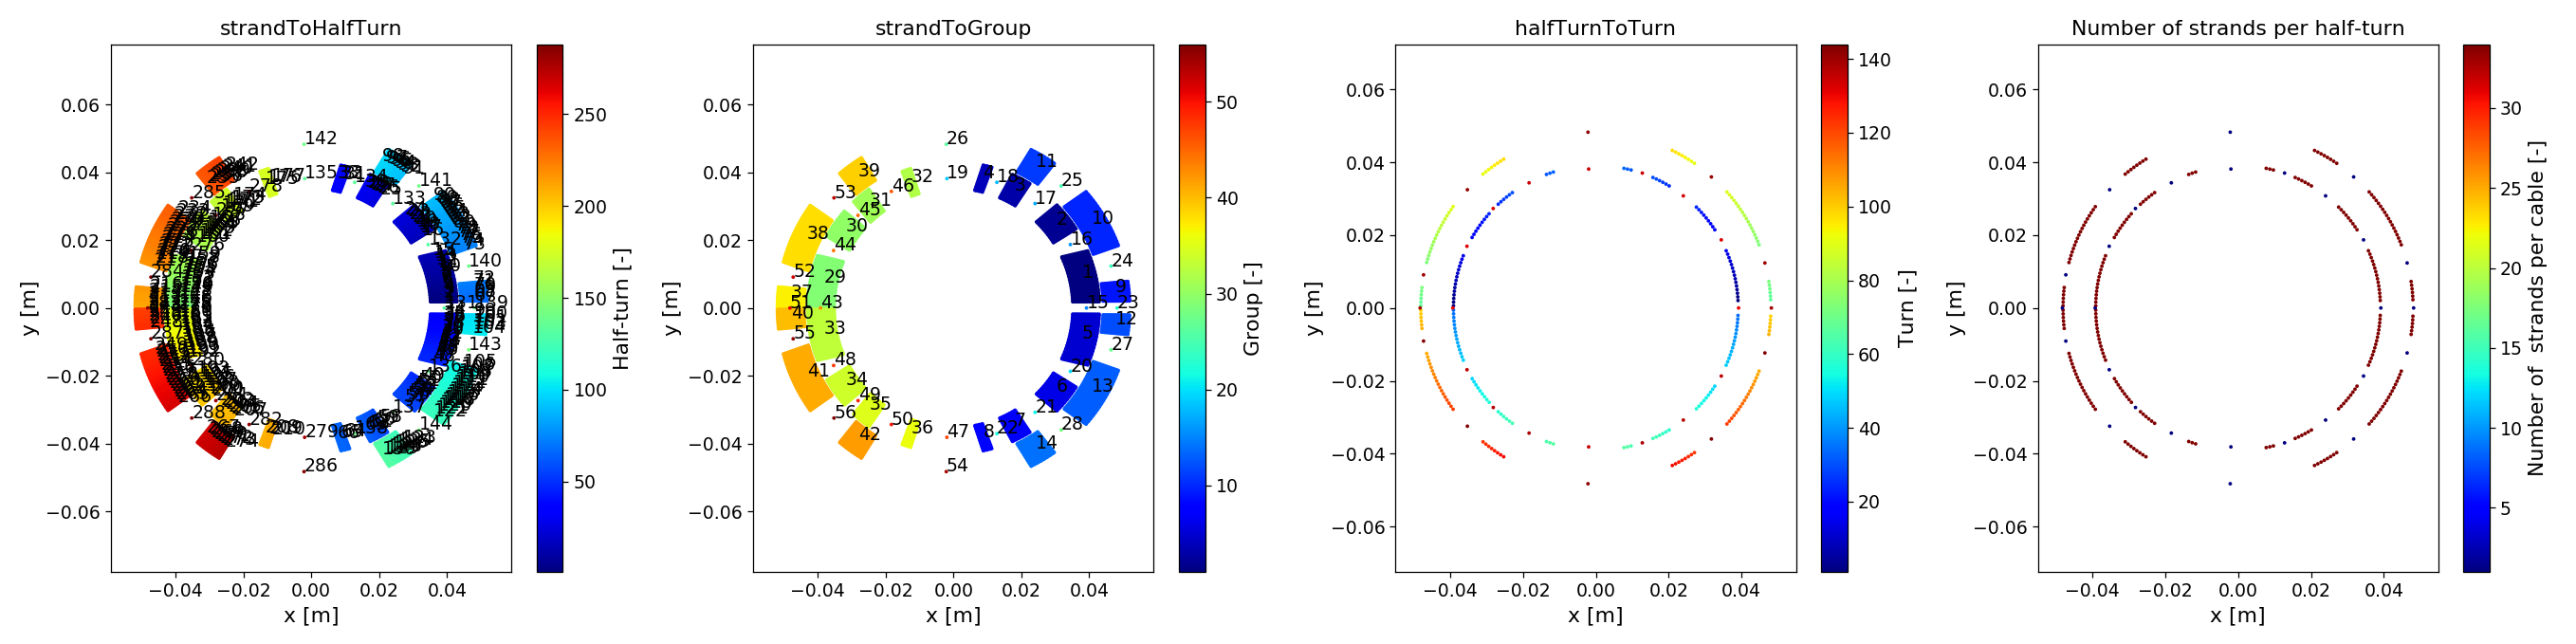

In [7]:
# Number of strands in each half-turn
nStrands = len(strandToGroup)
polarities = np.sign(I);
nHalfTurns = int(np.max(strandToHalfTurn));
nTurns = int(nHalfTurns/2)
nGroups = int(np.max(strandToGroup));
nS = []
for ht in range(1,nHalfTurns+1):
    #nS =sum(strandToHalfTurn==ht);
    nS = np.hstack([ nS, np.size(np.where(strandToHalfTurn==ht)) ]) # Number of strands in each half-turn
nS = np.int_(nS)

strandToGroup = np.int_(strandToGroup)
strandToHalfTurn = np.int_(strandToHalfTurn)
halfTurnToTurn=np.tile(np.arange(1,nTurns+1),2);

# Average half-turn positions
x_ave = []
y_ave = []
for ht in range(1,nHalfTurns+1):
    x_ave = np.hstack([ x_ave, np.mean( x[np.where(strandToHalfTurn==ht)] )])
    y_ave = np.hstack([ y_ave, np.mean( y[np.where(strandToHalfTurn==ht)] )])

# Average group positions
x_ave_group = []
y_ave_group = []
for g in range(1,nGroups+1):
    x_ave_group = np.hstack([ x_ave_group, np.mean( x[np.where(strandToGroup==g)] )])
    y_ave_group = np.hstack([ y_ave_group, np.mean( y[np.where(strandToGroup==g)] )])
    
print('Total number of strands = ' + str(nStrands))
print('Total number of half-turns = ' + str(nHalfTurns))
print('Total number of turns = ' + str(nTurns))
print('Total number of groups = ' + str(nGroups))


# Plot strand currents and magnetic field
f = plt.figure(figsize=(24,6))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=strandToHalfTurn)
for ht in range(nHalfTurns):
    plt.text(x_ave[ht], y_ave[ht], '{}'.format(ht + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToHalfTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Half-turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=strandToGroup)
for g in range(nGroups):
    plt.text(x_ave_group[g], y_ave_group[g], '{}'.format(g + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x_ave, y_ave, s=2, c=halfTurnToTurn)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('halfTurnToTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Number of strands per half-turn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Number of  strands per cable [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

# Overall magnet variables

In [8]:
T00 = 4.7
l_magnet = 1.73
I00 = 2144
Iref = 2144

# Definition of groups of conductors

1 coil sections defined.
56 groups defined.


<IPython.core.display.Javascript object>


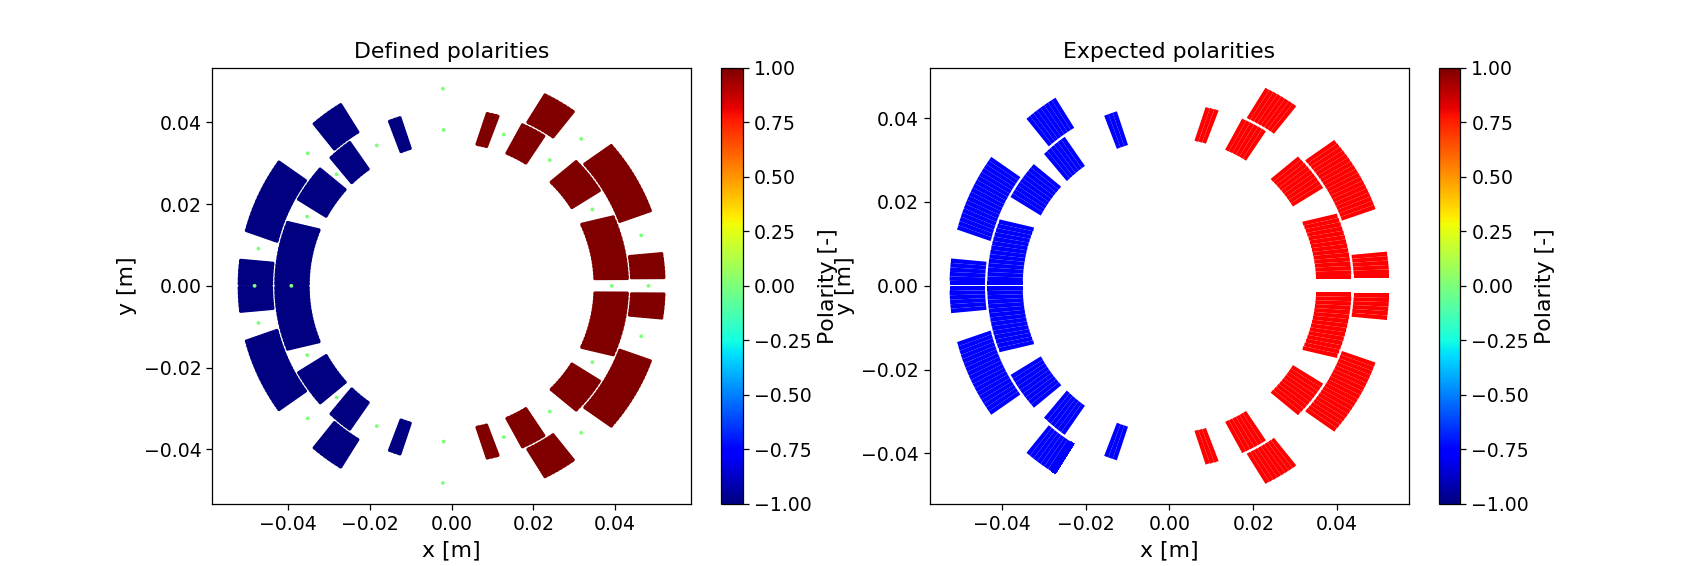

(-0.057704067721847746,
 0.05766887345871485,
 -0.051992908693531285,
 0.051992908693531285)

In [9]:
GroupToCoilSection = int(nGroups) * [1]
polarities_inGroup = int((nGroups-Number_Wedges)/2) * [+1] + NumberHalf_Wedges*[0] + \
                     int((nGroups-Number_Wedges)/2) * [-1] + NumberHalf_Wedges*[0]

# Count number of groups defined
nCoilSectionsDefined = np.max(GroupToCoilSection)
nGroupsDefined = len(GroupToCoilSection)

print(str(nCoilSectionsDefined) + ' coil sections defined.')
print(str(nGroupsDefined) + ' groups defined.')


# Plot defined current polarities
polarities_inStrand = np.zeros((1, nStrands), dtype=int)
polarities_inStrand = polarities_inStrand[0]
for g in range(1,nGroupsDefined+1):
    polarities_inStrand[np.where(strandToGroup==g)] = polarities_inGroup[g-1]
    
   

f = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(x, y, s=2, c=polarities_inStrand)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Defined polarities',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Polarity [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1,2,2)
# Plot edges
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r')
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='b')
    plt.gca().add_line(line)
plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Expected polarities', **selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Polarity [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

# Conductor properties in each group

In [10]:
#### Number of half-quadrants
nHalfQuadrants = 4

# Number of half-turns in each group
nHalfTurnsDefined = np.sum(nT)
# Number of strands in each cable belonging to a particular group
nStrands_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [34] + NumberHalf_Wedges*[1]+\
                   int((nGroupsDefined-Number_Wedges)/2) * [34] + NumberHalf_Wedges*[1]
# length of each half turn [m] (default=l_magnet)
l_mag_inGroup = int((nGroupsDefined-Number_Wedges)/2)* [l_magnet] + NumberHalf_Wedges*[l_magnet]+\
                int((nGroupsDefined-Number_Wedges)/2) * [l_magnet] + NumberHalf_Wedges*[l_magnet]
# strand diameter [m]
wedge_ds = np.sqrt( (np.array(wedge_areas) *4/np.pi))
ds_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [0.480E-3] + wedge_ds[:NumberHalf_Wedges].tolist() +\
             int((nGroupsDefined-Number_Wedges)/2)*  [0.480E-3] +wedge_ds[NumberHalf_Wedges:].tolist() # equivalent diameter; cross-section of wire 02 is in fact rectangular, of dimensions 0.67 mm x 0.32 mm
# fraction of superconductor in the strands
f_SC_strand_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [1/(1+1.75)] + NumberHalf_Wedges*[1e-9]+\
                      int((nGroupsDefined-Number_Wedges)/2) * [1/(1+1.75)] + NumberHalf_Wedges*[1e-9]# wire 02 specification: ≥ 4.0-4.8
# Effective transverse resistivity parameter (default=1)
f_ro_eff_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [1] + NumberHalf_Wedges*[10]+\
                   int((nGroupsDefined-Number_Wedges)/2) * [1] + NumberHalf_Wedges*[10]
# Filament twist-pitch [m]
Lp_f_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [0.015] + NumberHalf_Wedges*[0.001]+\
               int((nGroupsDefined-Number_Wedges)/2) * [0.015] + NumberHalf_Wedges*[0.001]# GUESS VALUE
# RRR of the conductor in each group of cables
RRR_Cu_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [150 /293*273] + NumberHalf_Wedges*[150 /293*273]+\
                 int((nGroupsDefined-Number_Wedges)/2) * [150 /293*273] + NumberHalf_Wedges*[150 /293*273] # type of superconductor (1=Nb-Ti, 2=Nb3Sn(Summer's fit), 3=BSCCO2212, 4=Nb3Sn(Bordini's fit))
SCtype_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [1] + NumberHalf_Wedges*[1]+\
                 int((nGroupsDefined-Number_Wedges)/2) * [1] + NumberHalf_Wedges*[1]
# type of stabilizer (1=Cu, 2=Ag)
STtype_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [1] + NumberHalf_Wedges*[1]+\
                 int((nGroupsDefined-Number_Wedges)/2) * [1] + NumberHalf_Wedges*[1]
# Type of cable insulation (1=G10, 2=kapton)
insulationType_inGroup = int((nGroupsDefined-Number_Wedges)/2) *  [2] + NumberHalf_Wedges*[2]+\
                         int((nGroupsDefined-Number_Wedges)/2) *  [2] + NumberHalf_Wedges*[2]
# Type of filler of voids between adjacent strands (1=G10, 2=kapton, 3=helium, 4=void)
internalVoidsType_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [1] + NumberHalf_Wedges*[1]+\
                            int((nGroupsDefined-Number_Wedges)/2) * [1] + NumberHalf_Wedges*[1]
# Type of filler of voids between strands and insulation layers (1=G10, 2=kapton, 3=helium, 4=void)
externalVoidsType_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [1] + NumberHalf_Wedges*[1]+\
                            int((nGroupsDefined-Number_Wedges)/2) * [1] + NumberHalf_Wedges*[1]
# bare cable width [m]
wBare_Cable = 8.30E-3
wIns = 80E-6
wEdge = 80E-6
wBare_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [wBare_Cable] + NumberHalf_Wedges*[(wBare_Cable+2*wIns)-2*wEdge]+\
                int((nGroupsDefined-Number_Wedges)/2) * [wBare_Cable] + NumberHalf_Wedges*[(wBare_Cable+2*wIns)-2*wEdge] 
# bare average cable height [m]
wedge_heights = (np.array(wedge_areas)/((wBare_Cable+2*wIns)-2*wEdge))
hBare_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [(0.78E-3+0.91E-3)/2] + wedge_heights[:NumberHalf_Wedges].tolist()+\
                int((nGroupsDefined-Number_Wedges)/2) * [(0.78E-3+0.91E-3)/2] + wedge_heights[NumberHalf_Wedges:].tolist()
# insulation thickness in the width direction [m]
wIns_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [wIns] + NumberHalf_Wedges*[wEdge]+\
               int((nGroupsDefined-Number_Wedges)/2) * [wIns] + NumberHalf_Wedges*[wEdge]
# insulation thickness in the height direction [m]
hIns_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [wIns] + NumberHalf_Wedges*[wEdge]+\
               int((nGroupsDefined-Number_Wedges)/2) * [wIns] + NumberHalf_Wedges*[wEdge]
# Strand twist-pitch [m]
Lp_s_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [66E-3] + NumberHalf_Wedges*[66E-3]+\
               int((nGroupsDefined-Number_Wedges)/2) * [66E-3] + NumberHalf_Wedges*[66E-3]
# Cross-contact resistance [Ohm]
R_c_inGroup = int((nGroupsDefined-Number_Wedges)/2) *  [100E-6] + NumberHalf_Wedges*[100E-6]+\
              int((nGroupsDefined-Number_Wedges)/2) *  [100E-6] + NumberHalf_Wedges*[100E-6]
# Tc0_NbTi_ht_inGroup [K]
Tc0_NbTi_ht_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [9.2] + NumberHalf_Wedges*[1e6]+\
                      int((nGroupsDefined-Number_Wedges)/2) * [9.2] + NumberHalf_Wedges*[1e6]
# Bc2_NbTi_ht_inGroup [T]
Bc2_NbTi_ht_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [14.5] + NumberHalf_Wedges*[1e6]+\
                      int((nGroupsDefined-Number_Wedges)/2) * [14.5] + NumberHalf_Wedges*[1e6]
# c1_Ic_NbTi_inGroup [A]
c1_Ic_NbTi_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [25941.2]+ NumberHalf_Wedges*[1e20]+\
                     int((nGroupsDefined-Number_Wedges)/2) * [25941.2]+ NumberHalf_Wedges*[1e20]
# c2_Ic_NbTi_inGroup [A/T]
c2_Ic_NbTi_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [-2078.1] + NumberHalf_Wedges*[1e20]+\
                     int((nGroupsDefined-Number_Wedges)/2) * [-2078.1]+ NumberHalf_Wedges*[1e20]
# Tc0_Nb3Sn [K]
Tc0_Nb3Sn_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [0] + NumberHalf_Wedges*[0]+\
                    int((nGroupsDefined-Number_Wedges)/2) * [0] + NumberHalf_Wedges*[0]
# Bc2_Nb3Sn [T]
Bc2_Nb3Sn_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [0] + NumberHalf_Wedges*[0]+\
                    int((nGroupsDefined-Number_Wedges)/2) * [0] + NumberHalf_Wedges*[0]
# Jc_Nb3Sn0 [A*T^0.5/m^2] Based on short-sample measurements
Jc_Nb3Sn0_inGroup = int((nGroupsDefined-Number_Wedges)/2) * [0] + NumberHalf_Wedges*[0]+\
                    int((nGroupsDefined-Number_Wedges)/2) * [0] + NumberHalf_Wedges*[0]

nHalfTurnsDefined = np.sum(nT)
print(str(nHalfTurnsDefined) + ' half-turns defined.')
print('')
#  Scale up or down the contribution of heat exchange through the short side of the cables (useful to change the insulation between coil layers
insulationBetweenLayers = 530E-6
insulationAroundCables = 80E-6
fScaling_Pex_AlongHeight_Defined = (2*insulationAroundCables)/(2*insulationAroundCables + insulationBetweenLayers)
print('fScaling_Pex_AlongHeight_Defined = ')
print(fScaling_Pex_AlongHeight_Defined)

288 half-turns defined.

fScaling_Pex_AlongHeight_Defined = 
0.23188405797101452


# Electrical order of the half-turns

The half-turns of these pairs of groups will be connected electrically:
[[1, 29], [2, 30], [3, 31], [4, 32], [9, 37], [10, 38], [11, 39], [5, 33], [6, 34], [7, 35], [8, 36], [12, 40], [13, 41], [14, 42], [15, 43], [16, 44], [17, 45], [18, 46], [19, 47], [20, 48], [21, 49], [22, 50], [23, 51], [24, 52], [25, 53], [26, 54], [27, 55], [28, 56]]


<IPython.core.display.Javascript object>


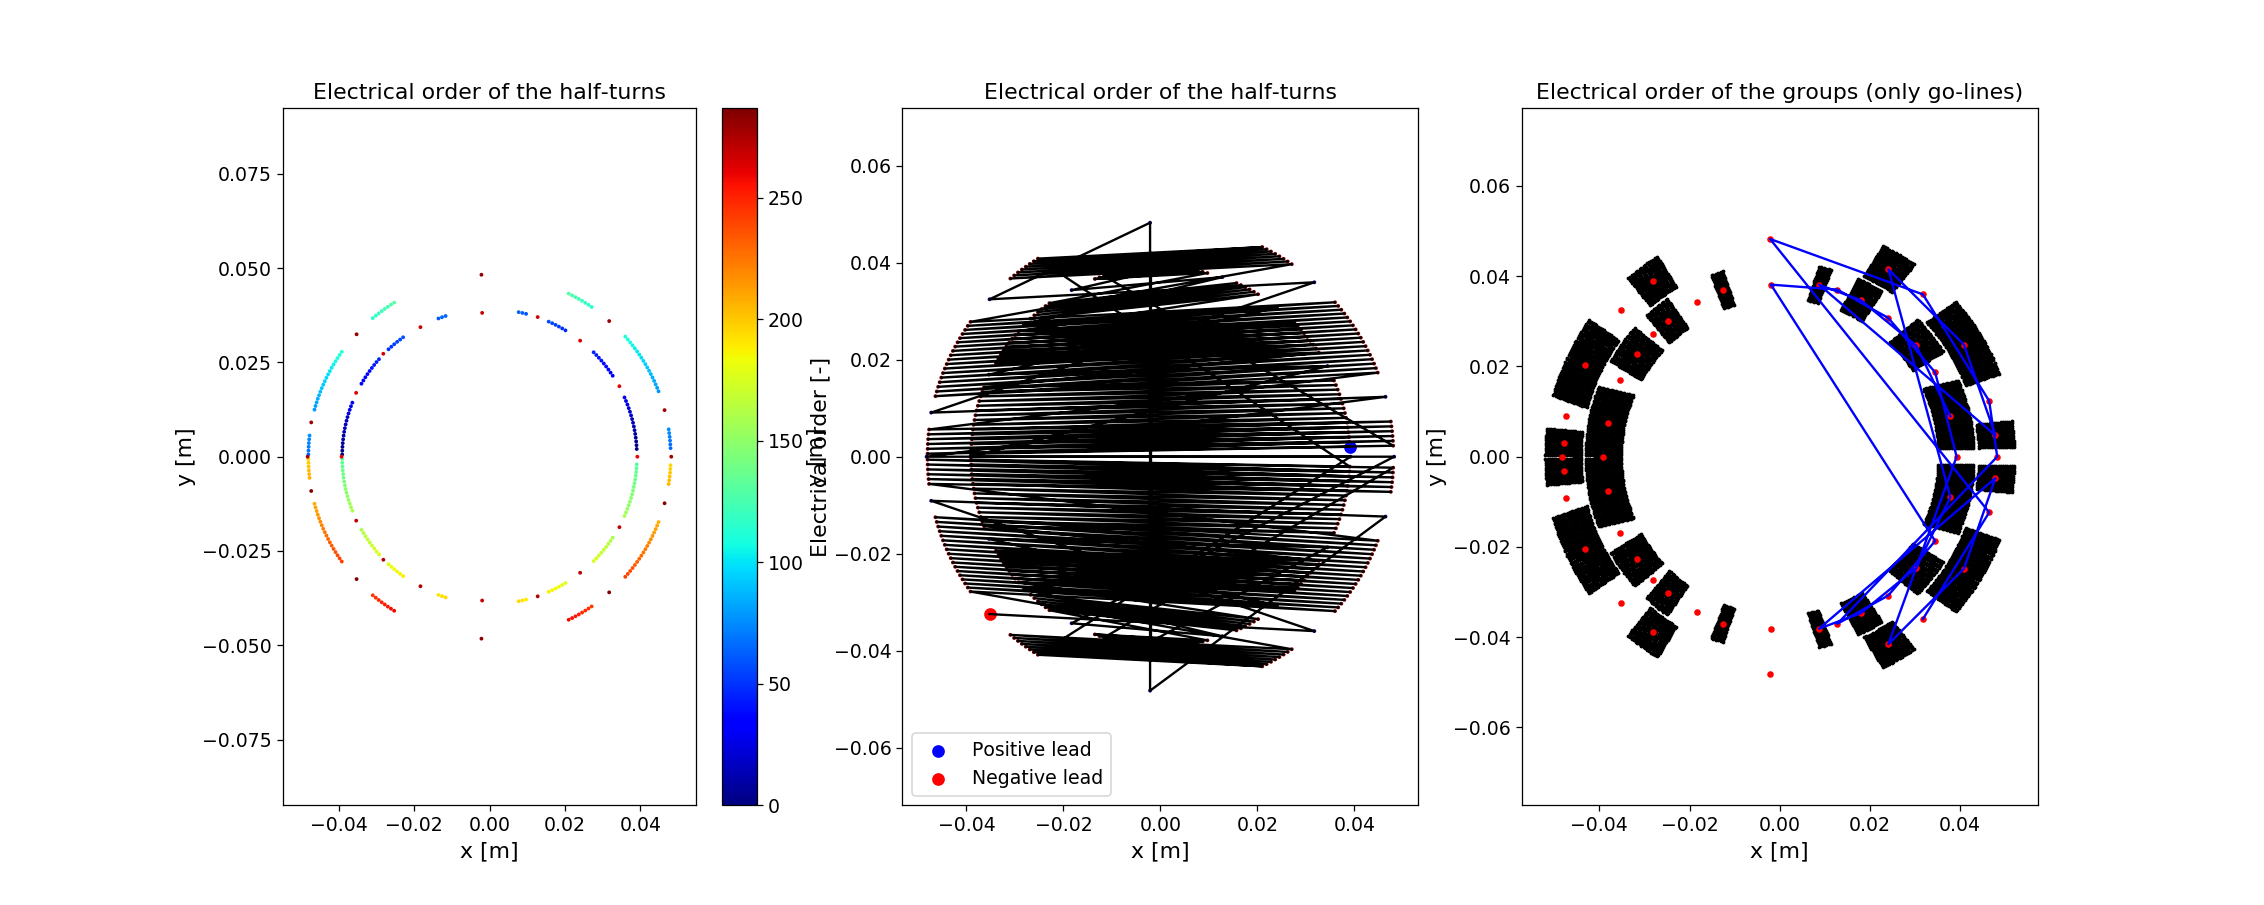

Calculated electrical order of the half-turns:
el_order_half_turns = [1, 145, 2, 146, 3, 147, 4, 148, 5, 149, 6, 150, 7, 151, 8, 152, 9, 153, 10, 154, 11, 155, 12, 156, 13, 157, 14, 158, 15, 159, 16, 160, 17, 161, 18, 162, 19, 163, 20, 164, 21, 165, 22, 166, 23, 167, 24, 168, 25, 169, 26, 170, 27, 171, 28, 172, 29, 173, 30, 174, 31, 175, 32, 176, 33, 177, 67, 211, 68, 212, 69, 213, 70, 214, 71, 215, 72, 216, 73, 217, 74, 218, 75, 219, 76, 220, 77, 221, 78, 222, 79, 223, 80, 224, 81, 225, 82, 226, 83, 227, 84, 228, 85, 229, 86, 230, 87, 231, 88, 232, 89, 233, 90, 234, 91, 235, 92, 236, 93, 237, 94, 238, 95, 239, 96, 240, 97, 241, 98, 242, 34, 178, 35, 179, 36, 180, 37, 181, 38, 182, 39, 183, 40, 184, 41, 185, 42, 186, 43, 187, 44, 188, 45, 189, 46, 190, 47, 191, 48, 192, 49, 193, 50, 194, 51, 195, 52, 196, 53, 197, 54, 198, 55, 199, 56, 200, 57, 201, 58, 202, 59, 203, 60, 204, 61, 205, 62, 206, 63, 207, 64, 208, 65, 209, 66, 210, 99, 243, 100, 244, 101, 245, 102, 246, 103, 247, 104, 248

In [11]:
# Start and end indices of each group
indexTstop = np.cumsum(nT)
indexTstop = indexTstop.tolist()
indexTstart = [1]
for i in range(len(nT)-1):
    indexTstart.extend([indexTstart[i] + nT[i]])

# # Fake electrical order
# el_order_half_turns = []
# for i in range(1,nHalfTurnsDefined+1):
#     el_order_half_turns.append(i)

# Calculation of the electrical order of the half-turns
# Pairs of groups whose half-turns are electrically connect (go and return lines)
elPairs_GroupTogether = [ [1,15], [2,16], [3,17], [4,18], [9,23], [10,24], [11,25], [5,19], [6,20], [7,21], [8,22], [12,26],
                         [13,27], [14,28] ]
# Correct for Wedges
elPairs_GroupTogether1 = [[x,y+int(Number_Wedges/2)] for x,y in elPairs_GroupTogether if y>TotalGroups/2]
elPairs_GroupTogether2 = [[x+int(Number_Wedges/2),y] for x,y in elPairs_GroupTogether if x>TotalGroups/2]
elPairs_GroupTogether =elPairs_GroupTogether1 + elPairs_GroupTogether2
# Add Wedges
for i in range(int(Number_Wedges/2)):
    elPairs_GroupTogether.append([int(TotalGroups/2)+i+1,int(Number_Wedges/2)+int(TotalGroups)+i+1])

# For each pair of groups, this flag determines whether the half-turns are electrically connected following LEDET order, or its inverse
elPairs_RevElOrder = [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ]
elPairs_RevElOrder = elPairs_RevElOrder+int(Number_Wedges/2)*[0]

nElPairs=len(elPairs_GroupTogether);

print('The half-turns of these pairs of groups will be connected electrically:')
print(elPairs_GroupTogether)

if len(elPairs_RevElOrder)!=nElPairs:
    raise Exception('Length of the vector elPairs_RevElOrder ({}) must be equal to nElPairs={}.'.format(len(elPairs_RevElOrder),nElPairs))

el_order_half_turns=[];
for p in range(nElPairs):
    if nT[elPairs_GroupTogether[p][0]-1]!=nT[elPairs_GroupTogether[p][1]-1]:
        raise Exception('Pair of groups defined by the variable elPairs_GroupTogether must have the same number of half-turns.')
    for k in range(nT[elPairs_GroupTogether[p][0]-1]):
        if elPairs_RevElOrder[p]==0:
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][0]-1]+k );
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][1]-1]+k );
        if elPairs_RevElOrder[p]==1:
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][0]-1]-k );
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][1]-1]-k );

el_order_half_turns_Array = np.int_(el_order_half_turns)
elPairs_GroupTogether_Array = np.int_(elPairs_GroupTogether)


# Plot
plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
plt.scatter(x_ave, y_ave, s=2, c=np.argsort(el_order_half_turns_Array))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Electrical order [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
# Plot
plt.subplot(1, 3, 2)
plt.plot(x_ave[el_order_half_turns_Array-1],y_ave[el_order_half_turns_Array-1],'k')
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.scatter(x_ave[el_order_half_turns_Array[0]-1], y_ave[el_order_half_turns_Array[0]-1], s=50, c='b', label='Positive lead')
plt.scatter(x_ave[el_order_half_turns_Array[-1]-1], y_ave[el_order_half_turns_Array[-1]-1], s=50, c='r', label='Negative lead')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.legend(loc='lower left')
# Plot
plt.subplot(1, 3, 3)
plt.plot(x_ave_group[elPairs_GroupTogether_Array[:,0]-1],y_ave_group[elPairs_GroupTogether_Array[:,0]-1],'b')
plt.scatter(x, y, s=2, c='k')
plt.scatter(x_ave_group, y_ave_group, s=10, c='r')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the groups (only go-lines)',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

print('Calculated electrical order of the half-turns:')
print('el_order_half_turns = {}'.format(el_order_half_turns))

<img src="MED_C_COMB_electricalOrder.png" width="750"/>

# Cable geometry parameters

In [12]:
# Inclination of cables with respect to X axis (including transformations for mirror and rotation)
alphasDEG_1 = (2* [0, 0.8974, 1.7948, 2.6922, 3.5896, 4.487, 5.3844, 6.2818, 7.1792, 8.0766, 8.974, 9.8714, 10.7688, 11.6662,
                   12.5636, 31.52, 32.4174, 33.3148, 34.2122, 35.1096, 36.007, 36.9044, 37.8018, 38.6992, 56, 56.8974, 
                   57.7948, 58.6922, 59.5896, 60.487, 69, 69.8974, 70.7948, ] 
                   + 2* [0, 0.8974, 1.7948, 2.6922, 3.5896, 4.487, 19, 19.8974, 20.7948, 21.6922, 22.5896, 23.487, 24.3844,
                         25.2818, 26.1792, 27.0766, 27.974, 28.8714, 29.7688, 30.6662, 31.5636, 32.461, 33.3584, 34.2558, 
                         51, 51.8974, 52.7948, 53.6922, 54.5896, 55.487, 56.3844, 57.2818 ] )
alphasDEG = alphasDEG_1 + NumberHalf_Wedges*[0] + alphasDEG_1 + NumberHalf_Wedges*[0]
# Rotate cable by a certain angle [deg]
rotation_block = \
33*[  0] + 33*[270] + \
32*[  0] + 32*[270] + \
NumberHalf_Wedges*[0]+\
33*[ 90] + 33*[180] + \
32*[ 90] + 32*[180] +\
NumberHalf_Wedges*[0]
# Mirror cable along the bisector of its quadrant (0=no, 1=yes)
mirror_block = \
33*[0] + 33*[1] + \
32*[0] + 32*[1] + \
NumberHalf_Wedges*[0]+\
33*[1] + 33*[0] + \
32*[1] + 32*[0] +\
NumberHalf_Wedges*[0]
# Mirror cable along the Y axis (0=no, 1=yes)
mirrorY_block = nHalfTurnsDefined * [0]


if len(alphasDEG)!=nHalfTurnsDefined:
    raise Exception('Length of the vector alphasDEG ({}) must be equal to nHalfTurnsDefined={}.'.format(len(alphasDEG),nHalfTurnsDefined))
if len(rotation_block)!=nHalfTurnsDefined:
    raise Exception('Length of the vector rotation_block ({}) must be equal to nHalfTurnsDefined={}.'.format(len(rotation_block),nHalfTurnsDefined))
if len(mirror_block)!=nHalfTurnsDefined:
    raise Exception('Length of the vector mirror_block ({}) must be equal to nHalfTurnsDefined={}.'.format(len(mirror_block),nHalfTurnsDefined))
if len(mirrorY_block)!=nHalfTurnsDefined:
    raise Exception('Length of the vector mirrorY_block ({}) must be equal to nHalfTurnsDefined={}.'.format(len(mirrorY_block),nHalfTurnsDefined))

# Heat exchange between half-turns along the cable wide side

In [13]:
# Pairs of half-turns exchanging heat along the cable wide side
iContactAlongWidth_From = []
iContactAlongWidth_To = []

for g in range(nGroupsDefined):
    iContactAlongWidth_From.extend( range(indexTstart[g], indexTstop[g]) )
    iContactAlongWidth_To.extend( range(indexTstart[g]+1, indexTstop[g]+1) )

# Find the n_layers closest Cables to the wedges
nLayers = 1
dummyFrom = []
dummyTo = []
for i in range(Number_Wedges):
    # Determine the current turn number of the wedge
    WedgeTurn = int((nHalfTurnsDefined/2)+i-Number_Wedges/2)+1
    if i>=Number_Wedges/2:
        WedgeTurn = WedgeTurn + int((nHalfTurnsDefined/2)-Number_Wedges/2)
    ProximityCable = np.zeros((nHalfTurnsDefined,1))
    # Calculate distance between every turn and the wedge center
    for j in range(nHalfTurnsDefined):
        ProximityCable[j] = np.sqrt((x_ave_wedge[i]/1000-x_ave[j])**2 + (y_ave_wedge[i]/1000-y_ave[j])**2)
    # Distance of the Wedge to itself = 'inf'
    ProximityCable[WedgeTurn-1] = 9999
    
    #Manipulate Pole-Wedge Connection - NOTE: Not generic, do not copy for anything else than MED_C_COMB
    if i==11:
        iContactAlongWidth_From.append(228+Number_Wedges/2)
        iContactAlongWidth_To.append(WedgeTurn)
        iContactAlongWidth_From.append(98)
        iContactAlongWidth_To.append(WedgeTurn)
        continue
    
    l = 0
    Wedge_Ortho = np.zeros((4,3))
    # Find nLayers*2 turns to thermally connect to wedge
    while l < nLayers*2:
        k = np.argmin(ProximityCable)
        # 1. Check: Check if Turn is on the edge of a block (max. of 1 azimuthal heat connection defined)
        indices = [i for i, x in enumerate(iContactAlongWidth_From) if x == k+1] + [i for i, x in enumerate(iContactAlongWidth_To) if x == k+1]
        ProximityCable[k] = ProximityCable[k]+9999
        if len(indices) >1: continue
        l = l+1
        # Construct Block edge as a line: center--> 2turns in block edge --> inf
        if l<=4:  Wedge_Ortho[l-1,:] = np.array([k, x_ave[k],y_ave[k]])
        if l==4:  Wedge_Ortho.view('i8,i8,i8').sort(order=['f0'], axis=0)
        if l>4:
            # 2. Check: Calculate distance of turn to Block edge. If > spec. numerical distance, discard
            new_Con = np.array([x_ave[k],y_ave[k]])
            # Side 1 of the wedge
            d_1 = np.linalg.norm(np.cross(Wedge_Ortho[1,1:]-Wedge_Ortho[0,1:], Wedge_Ortho[0,1:]-new_Con)) \
                                                /np.linalg.norm(Wedge_Ortho[1,1:]-Wedge_Ortho[0,1:])
            if d_1 < 1E-3:
                iContactAlongWidth_From.append(k+1)
                iContactAlongWidth_To.append(WedgeTurn)
                continue
            # Side 2 of the wedge
            d_2 = np.linalg.norm(np.cross(Wedge_Ortho[3,1:]-Wedge_Ortho[2,1:], Wedge_Ortho[2,1:]-new_Con)) \
                                                /np.linalg.norm(Wedge_Ortho[3,1:]-Wedge_Ortho[2,1:])
            if d_2 < 1E-3:
                iContactAlongWidth_From.append(k+1)
                iContactAlongWidth_To.append(WedgeTurn)
                continue
            l = l-1
        else:
            iContactAlongWidth_From.append(k+1)
            iContactAlongWidth_To.append(WedgeTurn)
    
    
print('Heat exchange along the cable wide side - Calculated indices:')
print('iContactAlongWidth_From = ')
print(iContactAlongWidth_From)
print('iContactAlongWidth_To = ')
print(iContactAlongWidth_To)

Heat exchange along the cable wide side - Calculated indices:
iContactAlongWidth_From = 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 64, 65, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 211, 212, 213, 214, 215, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 235, 236, 237, 238, 239, 24

# Heat exchange between half-turns along the cable narrow side

Heat exchange along the cable narrow side - Calculated indices:
iContactAlongHeight_From = 
[1, 2, 3, 3, 4, 4, 5, 5, 14, 15, 16, 17, 18, 19, 19, 20, 21, 22, 25, 25, 26, 26, 27, 28, 29, 34, 35, 36, 36, 37, 37, 38, 38, 47, 48, 49, 50, 51, 52, 52, 53, 54, 55, 58, 58, 59, 59, 60, 61, 62, 145, 145, 145, 146, 146, 147, 147, 148, 148, 149, 149, 155, 155, 156, 156, 157, 158, 159, 160, 160, 161, 161, 162, 162, 163, 164, 171, 172, 172, 173, 173, 174, 174, 178, 178, 179, 179, 180, 180, 181, 181, 182, 182, 188, 188, 189, 189, 190, 191, 192, 193, 193, 194, 194, 195, 195, 196, 197, 204, 205, 205, 206, 206, 207, 207, 211, 211, 243]
iContactAlongWidth_To = 
[67, 68, 69, 70, 71, 70, 71, 72, 73, 74, 83, 84, 85, 86, 87, 88, 89, 90, 93, 94, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 102, 103, 104, 105, 106, 115, 116, 117, 119, 118, 120, 121, 122, 125, 126, 127, 126, 128, 129, 130, 275, 211, 178, 213, 212, 214, 213, 214, 215, 215, 216, 218, 217, 218, 219, 220, 221, 222, 230, 229, 230, 231, 231, 232, 233, 

<IPython.core.display.Javascript object>


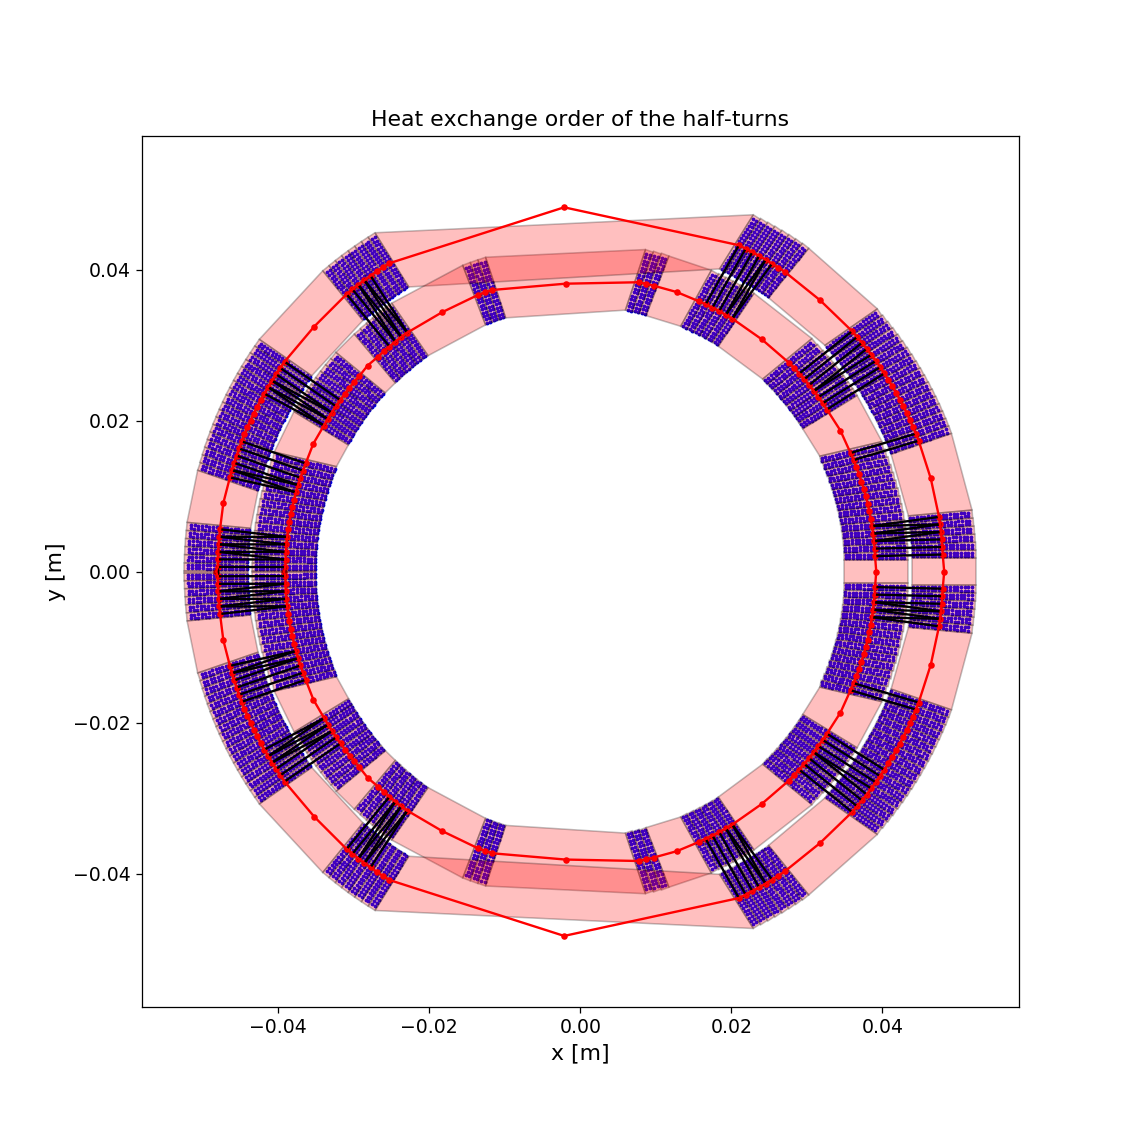

(-0.05811967043136157,
 0.058083770431361606,
 -0.054085152544552234,
 0.05408515254455218)

In [14]:
# This code will automatically find the half-turns that touch along the cable narrow side
# Half-turns will be thermally linked if:
# - they do not belong to the same conductor group, and
# - at least one strand of one half-turn is closer than max_distance to at least one strand of the other half-turn
# The code eliminates double repetition and orders the indices

# Prepare input for the function close_pairs_ckdtree
max_distance = 1.24E-3
X = np.column_stack((x, y))

# find all pairs of strands closer than a distance of max_d
pairs_close = close_pairs_ckdtree(X, max_distance)

# find pairs that belong to half-turns located in different groups
contact_pairs = set([])
for p in pairs_close:
    if not strandToGroup[p[0]] == strandToGroup[p[1]]:
        contact_pairs.add((strandToHalfTurn[p[0]],strandToHalfTurn[p[1]]))

# assign the pair values to two distinct vectors
iContactAlongHeight_From = []
iContactAlongHeight_To = []
for p in contact_pairs:
    iContactAlongHeight_From.append(p[0])
    iContactAlongHeight_To.append(p[1])

# find indices to order the vector iContactAlongHeight_From
idxSort = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(iContactAlongHeight_From))]

# reorder both iContactAlongHeight_From and iContactAlongHeight_To using the indices
iContactAlongHeight_From = [iContactAlongHeight_From[i] for i in idxSort]
iContactAlongHeight_To = [iContactAlongHeight_To[i] for i in idxSort]

print('Heat exchange along the cable narrow side - Calculated indices:')
print('iContactAlongHeight_From = ')
print(iContactAlongHeight_From)
print('iContactAlongWidth_To = ')
print(iContactAlongHeight_To)


# Plot
iContactAlongHeight_From_Array = np.int_(iContactAlongHeight_From)
iContactAlongHeight_To_Array = np.int_(iContactAlongHeight_To)
iContactAlongWidth_From_Array = np.int_(iContactAlongWidth_From)
iContactAlongWidth_To_Array = np.int_(iContactAlongWidth_To)

plt.figure(figsize=(10,10))
# plot strand positions
plt.scatter(x, y, s=2, c='b')
# plot conductors
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)
# plot average conductor positions
plt.scatter(x_ave, y_ave, s=10, c='r')
# plot heat exchange links along the cable narrow side
for i in range(len(iContactAlongHeight_From)):
    plt.plot([x_ave[iContactAlongHeight_From_Array[i]-1],x_ave[iContactAlongHeight_To_Array[i]-1]], [y_ave[iContactAlongHeight_From_Array[i]-1],y_ave[iContactAlongHeight_To_Array[i]-1]] ,'k')
# plot heat exchange links along the cable wide side
for i in range(len(iContactAlongWidth_From)):
    plt.plot([x_ave[iContactAlongWidth_From_Array[i]-1],x_ave[iContactAlongWidth_To_Array[i]-1]], [y_ave[iContactAlongWidth_From_Array[i]-1],y_ave[iContactAlongWidth_To_Array[i]-1]] ,'r')
# plot strands belonging to different conductor groups and closer to each other than max_distance
# for p in pairs_close:
#     if not strandToGroup[p[0]] == strandToGroup[p[1]]:
#         plt.plot([X[p[0], 0], X[p[1], 0]], [X[p[0], 1], X[p[1], 1]], c='g')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Heat exchange order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

# Quench initiation calculation: Force selected half-turns to quench

In [15]:
# Choose one of the two following options: Fully 2D model, or Experimental 2D+1D model

# # # # Fully 2D model
# # Indices of the half-turns that are set to quench at a given time
# iStartQuench = [100]
# # Time at which each selected half-turn quenches [s]
# tStartQuench = [-0.015]
# # Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
# lengthHotSpot_iStartQuench = [l_magnet]
# # Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
# vQ_iStartQuench = [99999]

# # # Experimental 2D + 1D model
# In this example, only one half-turn is quenched (#100). When it quenches at time tStartQuench, the half-turn electrical resistance will be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When the quench propagates to the three adjacent half-turns (#97-99), their resistances will also be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When any other half-turn in the model quenches, its resistance will be calculated using the full magnetic length.
# Indices of the half-turns that are set to quench at a given time
iStartQuench = [1]
# Time at which each selected half-turn quenches [s]
tStartQuench = [9999]
# Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
lengthHotSpot_iStartQuench = [10E-3]
# Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
vQ_iStartQuench = [9999]

# Electrical circuit during powering transient
<img src="../resources/LEDET_CircuitSchematic_Powering.png" width="750"/>


# Electrical circuit during protection transient
<img src="../resources/LEDET_CircuitSchematic_Protection.png" width="750"/>

# Circuit warm resistance and power-supply crowbar

In [16]:
# Resistance of the warm parts of the circuit [Ohm]
R_circuit = 0.000
# Resistance of crowbar of the power supply [Ohm]
R_crowbar = 0.000
# Forward voltage drop of a diode or thyristor in the crowbar of the power supply [V]
Ud_crowbar = 0.000

# Power supply control

<IPython.core.display.Javascript object>


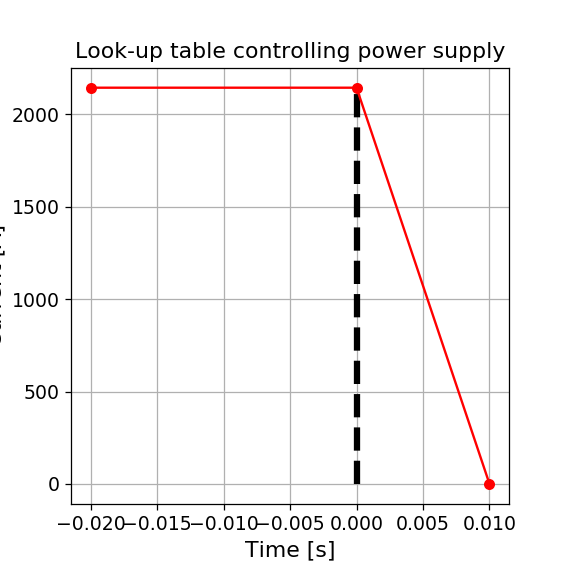

In [17]:
# Time when the power supply is switched off and the crowbar is switched on [s]
t_PC = 0
# LUT controlling power supply, Time [s]
t_PC_LUT = [-0.02, t_PC, t_PC+0.01]
# LUT controlling power supply, Current [A]
I_PC_LUT = [I00, I00, 0]

# Plot
plt.figure(figsize=(5,5))
plt.plot([t_PC,t_PC], [np.min(I_PC_LUT),np.max(I_PC_LUT)], 'k--', linewidth=4.0, label='t_PC')
plt.plot(t_PC_LUT, I_PC_LUT, 'ro-', label='LUT')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Current [A]',**selectedFont)
plt.title('Look-up table controlling power supply',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})

# Energy-extraction system

In [18]:
# Time when the energy-extraction system is triggered [s]
tEE = 0.005
# Resistance of the energy-extraction system [Ohm]
R_EE_triggered = 0.04

# CLIQ system

In [19]:
# Time when the CLIQ system is triggered [s]
tCLIQ = 99999
# Direction of the introduced current change for the chosen CLIQ configuration
directionCurrentCLIQ = [1]
# Number of CLIQ units
nCLIQ = 1
# CLIQ charging voltage [V]
U0 = 1000
# Capacitance of the CLIQ capacitor bank [F]
C = 0.04
# Resistance of the CLIQ leads [Ohm]
Rcapa = 0.05

# Quench heater parameters - QUENCH HEATERS NOT PRESENT

In [20]:
# Number of quench heater strips to write in the file
nHeaterStrips = 1

# Time at which the power supply connected to the QH strip is triggered (Low-field QHs set to a very large value to avoid triggering).
tQH = nHeaterStrips * [9999]
# Charging voltage of the capacitor connected to the QH strip.
U0_QH = nHeaterStrips * [0]
# Capacitance of the capacitor connected to the QH strip.
C_QH = nHeaterStrips * [7.05E-3*8]
# Resistance of the warm leads of the QH strip discharge circuit.
R_warm_QH = nHeaterStrips * [0.175] # 0.125-->0.175 Ohm partially compensates the fact that the real strip is 3.491 m long instead of l_magnet=3.400 m long
# Width of the non-Cu-plated part of the the QH strip.
w_QH = nHeaterStrips * [21E-3]
# Height of the non-Cu-plated part of the QH strip.
h_QH = nHeaterStrips * [25E-6]
# Thickness of the insulation layer between QH strip and coil insulation layer.
s_ins_QH = nHeaterStrips * [75E-6]
# Type of materialof the insulation layer between QH strip and coil insulation layer (1=G10; 2=kapton)
type_ins_QH = nHeaterStrips * [2]
# Thickness of the insulation layer between QH strip and the helium bath (or the collars); on this side, the QH strip is thermally connected to an infinite thermal sink at constant temperature.
s_ins_QH_He = nHeaterStrips * [500E-6]
# Type of material of the insulation layer between QH strip and helium bath (1=G10; 2=kapton)
type_ins_QH_He = nHeaterStrips * [2]
# Length of the QH strip
l_QH = nHeaterStrips * [l_magnet]
# Fraction of QH strip covered by heating stations (not-Cu-plated).
f_QH = nHeaterStrips * [0.12/(0.12+0.17)]

# Heat exchange between quench heater strips and half-turns - QUENCH HEATERS NOT PRESENT

In [21]:
iQH_toHalfTurn_From = [1]
iQH_toHalfTurn_To = [1]

# Adiabatic hot-spot temperature calculation

In [22]:
# Time from which the adiabatic hot-spot temperature calculation starts. For each coil section, calculate the adiabatic hot-spot temperature in the highest-field strand/cable [s]
tQuench = nCoilSectionsDefined * [-0.015]
# Initial quench temperature in the hot-spot temperature calculation [K]
initialQuenchTemp = nCoilSectionsDefined * [10]

# Self-mutual inductance matrix between half-turns, and between coil sections

In [23]:
# Self-mutual inductance calculation, using SMIC (https://cernbox.cern.ch/index.php/s/37F87v3oeI2Gkp3)
flag_strandCorrection = 0
flag_sumTurnToTurn = 1
flag_writeOutput = 0

# Calculate group to which each half-turn belongs
indexTstart = np.hstack([1, 1+np.cumsum(nT[:-1])]);
indexTstop = np.cumsum(nT);
HalfTurnToGroup = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToGroup = HalfTurnToGroup[0]
HalfTurnToCoilSection = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToCoilSection = HalfTurnToCoilSection[0]
for g in range(1,nGroupsDefined+1):
    HalfTurnToGroup[indexTstart[g-1]-1:indexTstop[g-1]] = g
    HalfTurnToCoilSection[indexTstart[g-1]-1:indexTstop[g-1]]=GroupToCoilSection[g-1]

# Calculate group to which each strand belongs
indexSstart = np.hstack([1, 1+np.cumsum(nS[:-1])]);
indexSstop = np.cumsum(nS);
strandToGroup = np.zeros((1, nStrands), dtype=int)
strandToGroup = strandToGroup[0]
strandToCoilSection = np.zeros((1, nStrands), dtype=int)
strandToCoilSection = strandToCoilSection[0]
for ht in range(1,nHalfTurnsDefined+1):
    strandToGroup[indexSstart[ht-1]-1:indexSstop[ht-1]] = HalfTurnToGroup[ht-1]
    strandToCoilSection[indexSstart[ht-1]-1:indexSstop[ht-1]]=HalfTurnToCoilSection[ht-1]

# Calculate diameter of each strand
Ds = np.zeros((1, nStrands), dtype=float)
Ds = Ds[0]
for g in range(1,nGroupsDefined+1):
    Ds[np.where(strandToGroup==g)] = ds_inGroup[g-1]


# Define self-mutual inductance calculation object
coil = SelfMutualInductanceCalculation(x, y, polarities, nS, Ds, strandToHalfTurn, strandToCoilSection, flag_strandCorrection, flag_sumTurnToTurn, flag_writeOutput, nameMagnet)

# Calculate self-mutual inductance between half-turns, turns, and coil-sections, per unit length [H/m]
M_halfTurns_calculated, M_turns_calculated, M_coilSections_calculated, L_mag0_calculated = coil.calculateInductance(x, y, polarities, nS, Ds, strandToHalfTurn, strandToCoilSection, flag_strandCorrection=0)

# Self-mutual inductances between coil sections, per unit length [H/m]
# Compensate slightly for added copper wedges
M_m = M_coilSections_calculated + Number_Wedges*1e-12
# Self-mutual inductances between turns, per unit length [H/m]
M_InductanceBlock_m = M_turns_calculated
# Set Self_inductance of wedge->wedge to zero (no influence of the wedges on other turns)
M_InductanceBlock_m[:,int(nHalfTurnsDefined/2)-NumberHalf_Wedges:]=np.zeros((int(nHalfTurnsDefined/2),NumberHalf_Wedges))
M_InductanceBlock_m[int(nHalfTurnsDefined/2)-NumberHalf_Wedges:,:]=np.zeros((NumberHalf_Wedges,int(nHalfTurnsDefined/2)))
# Total magnet self-mutual inductance, per unit length [H/m]
L_mag0 = L_mag0_calculated

print('')
print('Total magnet self-inductance per unit length: ' + str(L_mag0) + ' H/m')

# Defining to which inductive block each half-turn belongs
HalfTurnToInductanceBlock = range(1, int(nHalfTurnsDefined/2+1))
HalfTurnToInductanceBlock = []
for i in range(2):
    for j in range(1, int(nHalfTurnsDefined/2+1)):
        HalfTurnToInductanceBlock.append(j)

Self-mutual inductance between strands - Calculation started
Calculation does not include correction for strand diameter.
Status: [------------------->] 100%
Self-mutual inductance between strands - Calculation finished
Self-mutual inductance between half-turns - Calculation started
Self-mutual inductance between half-turns - Calculation finished
Self-mutual inductance between turns - Calculation started
Self-mutual inductance between turns - Calculation finished

Total magnet self-inductance per unit length: 0.007663940046195235 H/m


<IPython.core.display.Javascript object>


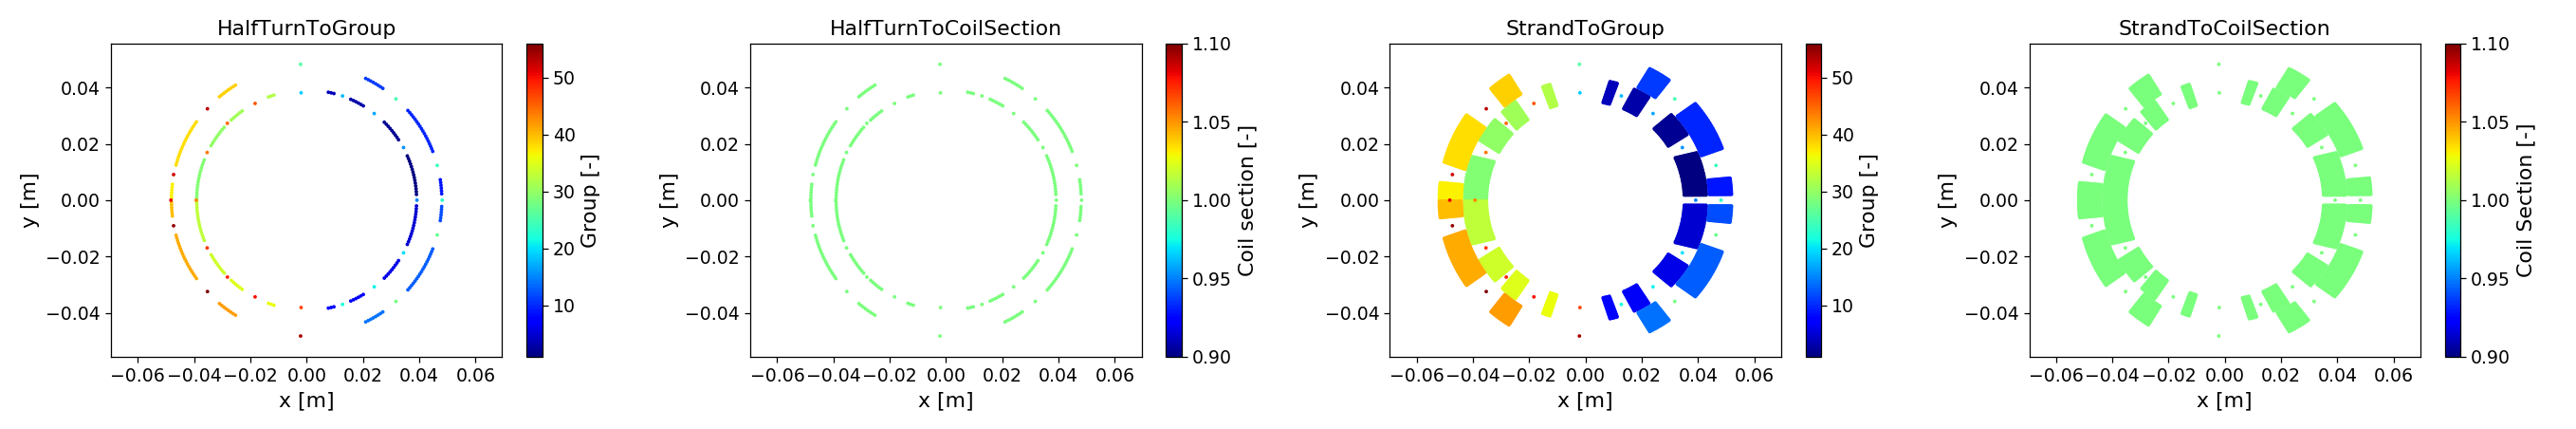

In [24]:
# Plot half-turn and strand properties
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil section [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=strandToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=strandToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil Section [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

# Differential inductance versus current (Iron-yoke effect) - IMPORT FROM ROXIE - TO DO

<IPython.core.display.Javascript object>


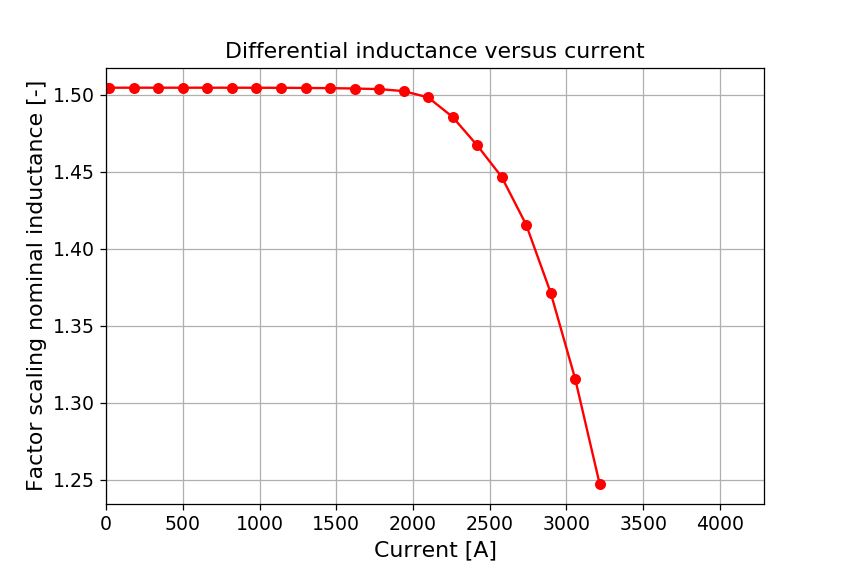

In [25]:
# Copy/paste the values after calculation using ROXIE or COMSOL or another software
fL_I = [0, 21.44, 181.168, 340.896, 500.624, 660.352, 820.08, 979.808, 1139.536, 1299.264, 1458.992, 1618.72, 1778.448, 1938.176, 2097.904, 2257.632, 2417.36, 2577.088, 2736.816, 2896.544, 3056.272, 3216 ]
fL_L = [1.50455507318679, 1.50455507318679, 1.50455507318679, 1.50455507318679, 1.50455507318679, 1.50455477302523, 1.50454550716827, 1.50451780095092, 1.50448925950139, 1.50439553079059, 1.50426788382312, 1.50401889328101, 1.50364485282149, 1.50234630169614, 1.49828433271297, 1.48556133232246, 1.46719162734847, 1.44670451745363, 1.41567010868495, 1.37155138330643, 1.31564552214063, 1.247307665915 ]

# Plot
f = plt.figure(figsize=(7.5,5))
plt.plot(fL_I, fL_L, 'ro-')
plt.xlabel('Current [A]',**selectedFont)
plt.ylabel('Factor scaling nominal inductance [-]',**selectedFont)
plt.title('Differential inductance versus current',**selectedFont)
plt.xlim([0, I00*2])
plt.grid(True)
plt.rcParams.update({'font.size': 12})

# Time Vector Definition

<IPython.core.display.Javascript object>


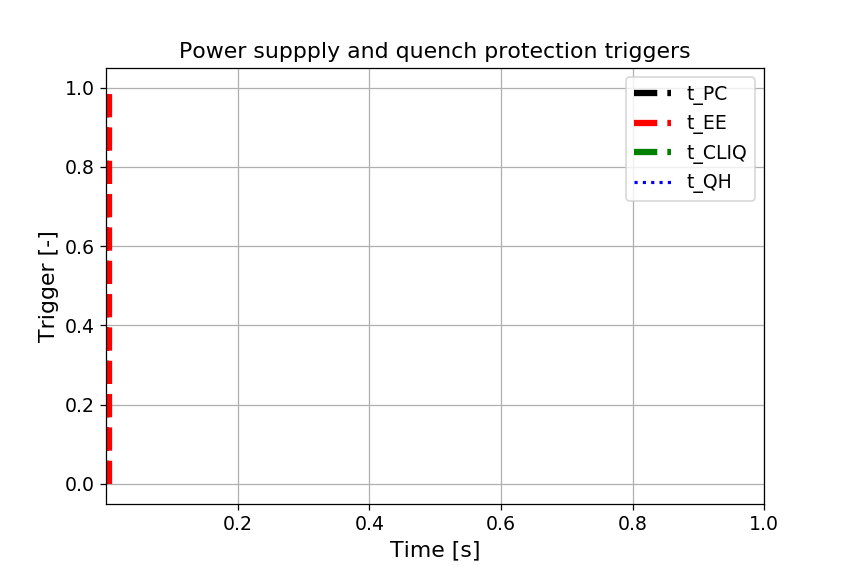

In [26]:
# Time Vector Definition. Parameters used to generate the time vector.
# Each triplet of numbers defines a time window: first element is the start time, second element is the time step in that window, third element is the end time. It must contain a number of elements multiple of 3. Any time point above t=1000 s will be ignored.
time_vector_params = [-0.02, 2.50E-05, -0.001, -0.000975, 2.50E-05, 0.04, 0.0405, 5.00E-04, 1]

# Plot
f = plt.figure(figsize=(7.5,5))
plt.plot([t_PC,t_PC], [0,1], 'k--', linewidth=4.0, label='t_PC')
plt.plot([tEE,tEE], [0,1], 'r--', linewidth=4.0, label='t_EE')
plt.plot([tCLIQ,tCLIQ], [0,1], 'g--', linewidth=4.0, label='t_CLIQ')
plt.plot([np.min(tQH),np.min(tQH)], [0,1], 'b:', linewidth=2.0, label='t_QH')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Trigger [-]',**selectedFont)
plt.xlim([1E-4,time_vector_params[-1]])
plt.title('Power suppply and quench protection triggers',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})
plt.legend(loc='best')

# Options - Change something only if you know what you're doing

In [27]:
# Field-Map Files Options
Iref = Iref
flagIron = 1
flagSelfField = 0
headerLines = 1
columnsXY = [4, 5]
columnsBxBy = [6, 7]
flagPlotMTF = 0

# Input Generation Options
flag_calculateInductanceMatrix = 0
flag_useExternalInitialization = 0
flag_initializeVar = 0

# Simulation Run Options
flag_fastMode = 1
flag_controlCurrent = 0
flag_automaticRefinedTimeStepping = 1

# Simulation Physics Options
flag_IronSaturation = 1
flag_InvertCurrentsAndFields = 0
flag_ScaleDownSuperposedMagneticField = 1
flag_HeCooling = 1
fScaling_Pex = 1
fScaling_Pex_AlongHeight = fScaling_Pex_AlongHeight_Defined
fScaling_MR = 1
flag_scaleCoilResistance_StrandTwistPitch = 2
flag_separateInsulationHeatCapacity = 0
flag_ISCL = 1
fScaling_Mif = 1
fScaling_Mis = 1
flag_StopIFCCsAfterQuench = 0
flag_StopISCCsAfterQuench = 0
tau_increaseRif = 0.005
tau_increaseRis = 0.01
fScaling_RhoSS = 1.09
maxVoltagePC = 10
flag_symmetricGroundingEE = 0
flag_removeUc = 0
BtX_background = 0
BtY_background = 0

# Post-Processing Options
flag_showFigures = 0
flag_saveFigures = 0
flag_saveMatFile = 1
flag_saveTxtFiles = 1
flag_generateReport = 1
flag_hotSpotTemperatureInEachGroup = 0
MinMaxXY_MTF = [-60, 60, -60, 60]

# Define the values of all Plots variables - Change something only if you know what you're doing

In [28]:
# Define the values of all Plots variables
suffixPlot = []
typePlot = []
outputPlotSubfolderPlot = []
variableToPlotPlot = []
selectedStrandsPlot = []
selectedTimesPlot = []
labelColorBarPlot = []
minColorBarPlot = []
maxColorBarPlot = []
MinMaxXYPlot = []
flagSavePlot = []
flagColorPlot = []
flagInvisiblePlot = []

# Define the values of all Variables variables - Change something only if you know what you're doing

In [29]:
# Define the values of all Variables variables
variableToSaveTxt = ['time_vector', 'Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH', 'T_s_QH', 'time_vector', 'R_CoilSections', 'U_inductive_dynamic_CoilSections']
typeVariableToSaveTxt = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1]
variableToInitialize = ['Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH', 'T_s_QH']

# Add all Inputs, Options, Plots, and Variables variables to a list - DO NOT CHANGE

In [30]:
# Load default LEDET variable descriptions
paramLEDET = ParametersLEDET()

# Add all Inputs variables to a list - DO NOT CHANGE
paramLEDET.addVariablesInputs(
    T00, l_magnet, I00, M_m,
    fL_I, fL_L,
    GroupToCoilSection, polarities_inGroup, nT,
    nStrands_inGroup, l_mag_inGroup, ds_inGroup,
    f_SC_strand_inGroup, f_ro_eff_inGroup, Lp_f_inGroup,
    RRR_Cu_inGroup,
    SCtype_inGroup, STtype_inGroup, insulationType_inGroup,
    internalVoidsType_inGroup,
    externalVoidsType_inGroup,
    wBare_inGroup, hBare_inGroup, wIns_inGroup, hIns_inGroup,
    Lp_s_inGroup, R_c_inGroup,
    Tc0_NbTi_ht_inGroup, Bc2_NbTi_ht_inGroup,
    c1_Ic_NbTi_inGroup, c2_Ic_NbTi_inGroup,
    Tc0_Nb3Sn_inGroup, Bc2_Nb3Sn_inGroup, Jc_Nb3Sn0_inGroup,
    el_order_half_turns,
    alphasDEG, rotation_block, mirror_block, mirrorY_block,
    iContactAlongWidth_From, iContactAlongWidth_To,
    iContactAlongHeight_From,
    iContactAlongHeight_To,
    iStartQuench, tStartQuench, lengthHotSpot_iStartQuench,
    vQ_iStartQuench,
    R_circuit, R_crowbar, Ud_crowbar, t_PC, t_PC_LUT, I_PC_LUT,
    tEE, R_EE_triggered,
    tCLIQ, directionCurrentCLIQ, nCLIQ, U0, C, Rcapa,
    tQH, U0_QH, C_QH, R_warm_QH, w_QH, h_QH, s_ins_QH, type_ins_QH,
    s_ins_QH_He, type_ins_QH_He, l_QH, f_QH,
    iQH_toHalfTurn_From, iQH_toHalfTurn_To,
    tQuench, initialQuenchTemp,
    HalfTurnToInductanceBlock, M_InductanceBlock_m
)

# Add all Options variables to a list - DO NOT CHANGE
paramLEDET.addVariablesOptions(
    time_vector_params,
    Iref, flagIron, flagSelfField, headerLines, columnsXY, columnsBxBy, flagPlotMTF,
    flag_calculateInductanceMatrix, flag_useExternalInitialization, flag_initializeVar,
    flag_fastMode, flag_controlCurrent, flag_automaticRefinedTimeStepping, flag_IronSaturation,
    flag_InvertCurrentsAndFields, flag_ScaleDownSuperposedMagneticField, flag_HeCooling, fScaling_Pex, fScaling_Pex_AlongHeight,
    fScaling_MR, flag_scaleCoilResistance_StrandTwistPitch, flag_separateInsulationHeatCapacity,
    flag_ISCL, fScaling_Mif, fScaling_Mis, flag_StopIFCCsAfterQuench, flag_StopISCCsAfterQuench, tau_increaseRif, tau_increaseRis,
    fScaling_RhoSS, maxVoltagePC, flag_symmetricGroundingEE, flag_removeUc, BtX_background, BtY_background,
    flag_showFigures, flag_saveFigures, flag_saveMatFile, flag_saveTxtFiles, flag_generateReport,
    flag_hotSpotTemperatureInEachGroup, MinMaxXY_MTF
)

# Define the values of all Plots variables - DO NOT CHANGE
paramLEDET.addVariablesPlots(
    suffixPlot, typePlot, outputPlotSubfolderPlot, variableToPlotPlot, selectedStrandsPlot, selectedTimesPlot,
    labelColorBarPlot, minColorBarPlot, maxColorBarPlot, MinMaxXYPlot, flagSavePlot, flagColorPlot, flagInvisiblePlot
)

# Define the values of all Variables variables - DO NOT CHANGE
paramLEDET.addVariablesVariables(
    variableToSaveTxt, typeVariableToSaveTxt, variableToInitialize
)

# Visualize the defined variables

In [31]:
if verbose:
    # Visualize variable descriptions, names, and values
    print('### "Inputs" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupInputs, paramLEDET.variablesInputs)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Options" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupOptions, paramLEDET.variablesOptions)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Plots" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupPlots, paramLEDET.variablesPlots)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Variables" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupVariables, paramLEDET.variablesVariables)

# Write the LEDET input file

In [32]:
nameFileLEDET = nameMagnet + '_CopperWedges_0' + '.xlsx'
paramLEDET.writeFileLEDET(nameFileLEDET)

Preliminary consistency check was successful!
